# Project: Tracking the International Space Station (ISS)
## Avik Banerjee
#### E-mail: avik2020.phys@gmail.com

In this Project, we’ll delve into fundamental concepts in both astronomy and programming, such as:

- **Location data processing**: Translating city names into geographic coordinates.
- **Satellite motion modeling**: Leveraging TLE (Two-Line Element) data to compute orbital paths.
- **Python ecosystem**: Utilizing libraries like `skyfield`, `geopy`, `astropy`, `requests`, and `matplotlib`.
- **Data visualization**: Creating plots to illustrate the ISS’s trajectory across the Earth’s surface.


## Prerequisites

To run the ISS tracking application, you’ll need Python 3.8 or later, along with a functional internet connection to fetch real-time orbital data. A modern code editor such as Visual Studio Code or PyCharm is recommended for development.

The project depends on several Python libraries:

- `requests` handles the retrieval of live data over the web.
- `skyfield` is used for orbital mechanics and satellite positioning.
- `numpy` supports array-based numerical computations.
- `matplotlib` is used to visualize the ISS ground track.
- `ipywidgets` enables interactive UI elements within Jupyter notebooks.


## 🔧 Setup – Installing and Importing Required Libraries

### 🎯 Goal:
The purpose of this task is to prepare the working environment by ensuring all the necessary Python libraries are installed and ready to use.

---

### 📦 Step 1: Installing Libraries

Library installation is done through a package manager such as `pip` or `conda`, depending on the Python environment being used. This process typically involves opening a terminal (or the Anaconda Prompt if using Anaconda) and executing the appropriate installation commands for each required package.

For example, using `pip`:
```bash
pip install <library-name>


### 📥 Importing Required Libraries

To perform ISS tracking and visualization, the following Python libraries are used:

- **Skyfield**: Handles astronomical calculations and allows us to work with satellite TLE data to compute positions and passes.
- **Geopy**: Converts city names into geographic coordinates (latitude and longitude) using geocoding services like Nominatim.
- **Requests**: Used to make HTTP requests for retrieving real-time data, such as satellite orbital elements (TLE) from online sources like CelesTrak.
- **NumPy**: Supports numerical operations and efficient handling of arrays and mathematical computations.
- **Matplotlib**: Used for plotting visualizations, such as satellite ground tracks or altitude-over-time graphs.
- **Datetime**: Provides functions for working with and manipulating dates and times.
- **ipywidgets & IPython.display**: Enables interactive widgets (e.g., dropdowns, buttons) and dynamic output display within Jupyter notebooks to enhance user interaction.



In [25]:
from skyfield.api import load, EarthSatellite, Topos
from geopy.geocoders import Nominatim
import requests
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import ipywidgets as widgets
from IPython.display import display, clear_output

### 📡 Fetching the Latest ISS TLE Data

To track the International Space Station (ISS), we first need its most recent orbital data, provided in the form of a Two-Line Element (TLE) set. This data is publicly available from CelesTrak, a trusted source for satellite tracking information.

The TLE information is retrieved from the `stations.txt` file hosted by CelesTrak. This file contains TLEs for various satellites, including the ISS. A simple function can be used to scan through this file and extract the three necessary lines corresponding to the ISS: the name line and the two TLE lines that describe its orbit.

If the ISS entry is not found, an exception is raised to alert the user.

---

### 🛰️ Creating a Satellite Object with Skyfield

Once the TLE data is obtained, the Skyfield library is used to parse it. A time scale object is first initialized using Skyfield's `load.timescale()` method. Then, the TLE lines are passed to create an `EarthSatellite` object.

This satellite object represents the ISS and allows us to calculate its position, velocity, and visibility from any location on Earth at any given time. It forms the basis for all subsequent tracking and visualization tasks.


In [26]:
# Function to retrieve the latest TLE data for the ISS from CelesTrak
def fetch_iss_tle():
    url = "https://celestrak.org/NORAD/elements/stations.txt"
    response = requests.get(url)
    tle_lines = response.text.strip().splitlines()

    for i, line in enumerate(tle_lines):
        if "ISS" in line:
            name = line.strip()
            line1 = tle_lines[i + 1].strip()
            line2 = tle_lines[i + 2].strip()
            return name, line1, line2

    raise RuntimeError("ISS TLE not found in CelesTrak data.")

# Create a Skyfield satellite object using the fetched TLE data
ts = load.timescale()
name, line1, line2 = fetch_iss_tle()
satellite = EarthSatellite(line1, line2, name, ts)



### 🌍 Getting Coordinates from City Name

To determine the location of the observer on Earth, we need to convert the name of a city into its geographical coordinates (latitude and longitude). This is achieved using the **Geopy** library, specifically the `Nominatim` geocoder.

The function accepts a city name as input and returns a tuple containing the latitude and longitude of that location. It also includes basic input sanitization by trimming any leading or trailing spaces from the city name.

If the city cannot be found, the function raises a `ValueError` with a helpful message, prompting the user to check the spelling or try a different input.

This geolocation step is essential for calculating the position of the ISS relative to a specific point on Earth.


In [27]:
# Function to get latitude and longitude of a given city using Geopy
def get_coords(city_name):
    geolocator = Nominatim(user_agent="iss_tracker_app")
    location = geolocator.geocode(city_name.strip())

    if location is None:
        raise ValueError(f"City '{city_name}' not found. Please check the spelling and try again.")
    
    return location.latitude, location.longitude



### 🔭 Calculating the Next ISS Pass Over a Given City

This function is designed to calculate and display the next visible pass of the International Space Station (ISS) over a city specified by the user.

#### 📌 Key Steps Involved:

- **Time Setup**:  
  It begins by loading Skyfield's time scale and getting the current UTC time. A 24-hour observation window is defined to look for upcoming passes.

- **Geolocation**:  
  The latitude and longitude of the city are obtained using the previously defined `get_coords()` function. These coordinates are used to create an observer's location on Earth using Skyfield’s `Topos` class.

- **Event Search**:  
  Skyfield's `find_events()` method is used to identify three key events during the ISS pass:
  - **Rise 🌅** – when the ISS appears above the horizon
  - **Culmination 🌕** – when the ISS reaches its highest point in the sky
  - **Set 🌇** – when the ISS disappears below the horizon

- **Output**:  
  The function prints the UTC time for each of these events, formatted for readability.

This makes it easy to know when and where to look in the sky to observe the ISS from any city on Earth.


In [28]:
from datetime import datetime, timedelta
from skyfield.api import load, EarthSatellite, Topos, utc

# Function to calculate and display the next ISS pass for a given city
def next_pass(city_name):
    # Load current time scale from Skyfield
    ts = load.timescale()

    # Get latitude and longitude of the input city
    lat, lon = get_coords(city_name)
    location = Topos(latitude_degrees=lat, longitude_degrees=lon)

    # Get the current UTC time and define a 24-hour observation window
    now_utc = datetime.now(tz=utc)
    end_utc = now_utc + timedelta(days=1)

    # Convert times to Skyfield time objects
    t0 = ts.from_datetime(now_utc)
    t1 = ts.from_datetime(end_utc)

    # Find ISS events: rise, culmination, and set over the location
    times, events = satellite.find_events(location, t0, t1, altitude_degrees=30.0)

    # Map event codes to human-readable names and print results
    event_names = ['Rise 🌅', 'Culminate 🌕', 'Set 🌇']
    for time, event in zip(times, events):
        print(f"{event_names[event]}: {time.utc_datetime():%Y-%m-%d %H:%M:%S UTC}")





In [29]:
next_pass("Kolkata")

Rise 🌅: 2025-07-23 17:02:47 UTC
Culminate 🌕: 2025-07-23 17:04:17 UTC
Set 🌇: 2025-07-23 17:05:47 UTC


### 🌍 Plotting the ISS Ground Track

This function visualizes the **ground track** of the International Space Station (ISS), i.e., the path it traces over the Earth's surface as it orbits.

#### 📌 What the Function Does:

- **Time Setup**:  
  It begins by capturing the current UTC time and generates a list of timestamps for the next *N* minutes (default is 90 minutes).

- **Position Calculation**:  
  For each timestamp, the ISS’s subpoint (the location on Earth directly beneath the satellite) is calculated using Skyfield. This gives a series of latitude and longitude values representing the satellite’s path.

- **Visualization**:  
  The function uses Matplotlib to plot:
  - The **ISS path** over time (as a line).
  - The **current location** of the ISS (as a red dot).
  
  The plot includes labeled axes, a grid, a dynamic title showing the duration, and a legend for clarity.

This graphical output helps users understand how the ISS moves across the globe over a short future period.


In [30]:
from datetime import datetime, timedelta, timezone

# Function to plot the ISS ground track for a given duration
def plot_ground_track(duration_minutes=90):
    # Load time scale and define time range
    ts = load.timescale()
    start_time = datetime.now(timezone.utc)
    datetimes = [start_time + timedelta(minutes=i) for i in range(duration_minutes)]
    times = ts.from_datetimes(datetimes)

    # Calculate latitude and longitude for each time step
    lats, lons = [], []
    for t in times:
        subpoint = satellite.at(t).subpoint()
        lats.append(subpoint.latitude.degrees)
        lons.append(subpoint.longitude.degrees)

    # Plot the ground track
    plt.figure(figsize=(12, 6))
    plt.plot(lons, lats, label="ISS Path", linewidth=2)
    plt.scatter(lons[0], lats[0], color='red', label="Current Position", zorder=5)
    plt.title(f"ISS Ground Track (Next {duration_minutes} Minutes)", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



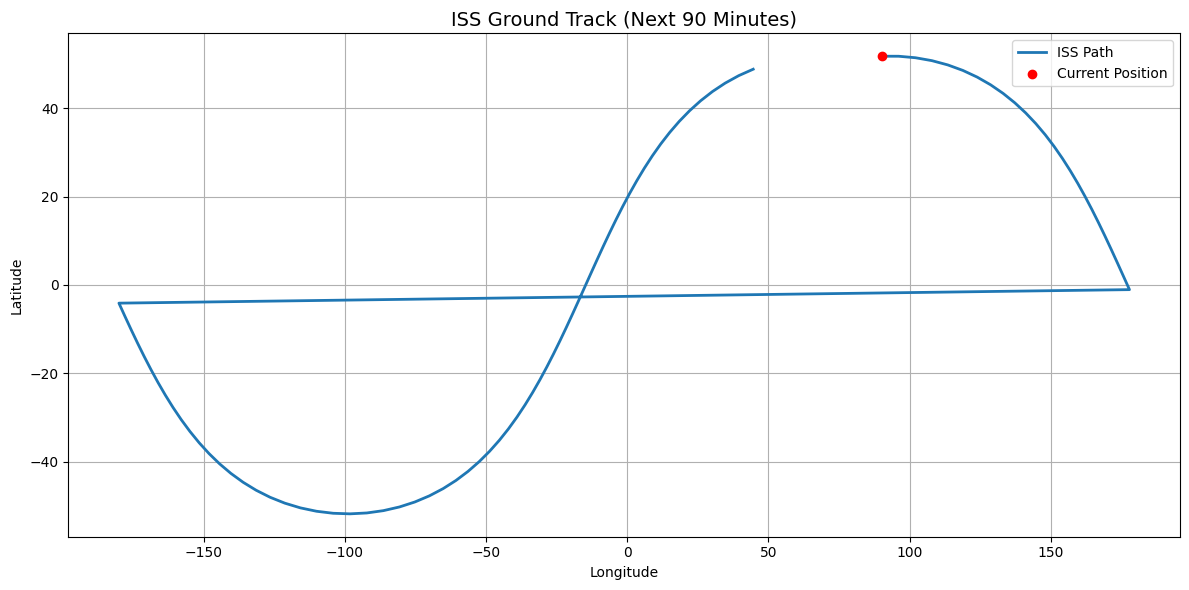

In [31]:
plot_ground_track()


### 📋 Batch ISS Pass Predictions for Multiple Cities

This function calculates the next visible ISS pass for a list of cities provided in a CSV file. Each city's entry includes its name, latitude, and longitude.

#### 📌 How It Works:

- **Time Window**:  
  The function defines a 24-hour observation period starting from the current UTC time.

- **Input File**:  
  It reads a CSV file containing multiple cities. Each row must include the following columns:
  - `City`: Name of the city
  - `Latitude`: Geographic latitude in decimal degrees
  - `Longitude`: Geographic longitude in decimal degrees

- **Pass Calculation**:  
  For each city, the ISS pass is computed using Skyfield’s `find_events()` function, which detects:
  - **Rise** 🌅 – When the ISS appears above 30° elevation.
  - **Culmination** 🌕 – The highest point in the sky during the pass.
  - **Set** 🌇 – When the ISS disappears below the 30° elevation.

- **Output**:  
  The results are printed in a tabular format, showing each city along with the UTC timestamps for the rise, culmination, and set events.

- **Error Handling**:  
  If the ISS does not pass over a given city within the time window, or if the pass data is incomplete, the function reports it gracefully.

This batch-processing approach is useful for comparing ISS visibility across multiple locations at once.


In [32]:
import csv
from datetime import datetime, timedelta, timezone

# Function to calculate and display ISS passes for multiple cities from a CSV file
def batch_iss_passes(csv_file):
    # Define the time window: now to 24 hours ahead
    t0 = ts.from_datetime(datetime.now(timezone.utc))
    t1 = ts.from_datetime(datetime.now(timezone.utc) + timedelta(days=1))

    # Print table headers
    print(f"{'City':<20} {'Rise Time':<25} {'Culmination':<25} {'Set Time':<25}")

    # Read the CSV file containing city names and coordinates
    with open(csv_file, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            city = row['City']
            lat = float(row['Latitude'])
            lon = float(row['Longitude'])
            location = Topos(latitude_degrees=lat, longitude_degrees=lon)

            try:
                # Calculate ISS pass events (rise, culmination, set)
                times, events = satellite.find_events(location, t0, t1, altitude_degrees=30.0)

                # Extract and format event times
                rise_time = times[0].utc_datetime().strftime('%Y-%m-%d %H:%M:%S UTC')
                culminate_time = times[1].utc_datetime().strftime('%Y-%m-%d %H:%M:%S UTC')
                set_time = times[2].utc_datetime().strftime('%Y-%m-%d %H:%M:%S UTC')

                # Print formatted results
                print(f"{city:<20} {rise_time:<25} {culminate_time:<25} {set_time:<25}")

            except Exception:
                # Gracefully handle missing or failed pass calculations
                print(f"{city:<20} Pass data unavailable or insufficient.")


In [33]:
batch_iss_passes(r"C:\Users\COSMOS\Downloads\locations.csv")


City                 Rise Time                 Culmination               Set Time                 
Delhi                2025-07-23 17:00:09 UTC   2025-07-23 17:01:15 UTC   2025-07-23 17:02:21 UTC  
Mumbai               2025-07-23 18:37:53 UTC   2025-07-23 18:39:06 UTC   2025-07-23 18:40:20 UTC  
Bengaluru            2025-07-23 18:39:56 UTC   2025-07-23 18:41:08 UTC   2025-07-23 18:42:21 UTC  
Kolkata              2025-07-23 17:02:47 UTC   2025-07-23 17:04:17 UTC   2025-07-23 17:05:47 UTC  
Hyderabad            2025-07-24 07:58:54 UTC   2025-07-24 08:00:15 UTC   2025-07-24 08:01:35 UTC  


### 🧭 Interactive Controls for ISS Tracking

To make ISS tracking user-friendly, the following interactive widgets are created using `ipywidgets`:

#### 📍 City Selector
- A **dropdown menu** allows the user to select one of several predefined Indian cities.
- Each city is mapped to its corresponding latitude and longitude.
- This determines the observer's location on Earth.

#### ⏱️ Tracking Duration Slider
- An **integer slider** lets the user choose how many minutes of the ISS ground track to visualize.
- The slider ranges from **30 to 180 minutes**, with a default of **90 minutes**, adjustable in 10-minute steps.

#### 🚀 Run Button
- A **button widget** labeled "Track ISS" triggers the computation and visualization.
- It provides a clean way to activate the ground track plotting based on the selected city and duration.

#### 📤 Output Display
- An **output area** is included to display the results—such as maps, pass times, or messages—generated when the button is clicked.

These widgets together create an interactive interface, allowing users to explore ISS visibility from different cities in a flexible and engaging way.


In [34]:
# Predefined city coordinates (latitude, longitude)
cities = {
    "Delhi": (28.6139, 77.2090),
    "Mumbai": (19.0760, 72.8777),
    "Bengaluru": (12.9716, 77.5946),
    "Kolkata": (22.5726, 88.3639),
    "Hyderabad": (17.3850, 78.4867)
}

# Dropdown widget to select a city
city_dropdown = widgets.Dropdown(
    options=cities.keys(),
    value="Delhi",
    description='City:',
    style={'description_width': 'initial'}
)

# Slider widget to set tracking duration in minutes
duration_slider = widgets.IntSlider(
    value=90,
    min=30,
    max=180,
    step=10,
    description='Track (min):',
    style={'description_width': 'initial'}
)

# Button to trigger the ISS tracking
run_button = widgets.Button(
    description="Track ISS",
    button_style='primary'
)

# Output widget to display results
output = widgets.Output()



### 🚀 Running ISS Tracking for a Selected City

This function combines two core tasks:
1. **Predicting the next visible ISS pass** over a selected city.
2. **Plotting the ISS ground track** over a specified duration.

#### 📌 Function Overview:

- **Input Parameters**:
  - `city`: Name of the selected city (must exist in the predefined `cities` dictionary).
  - `duration`: Duration in minutes for which the ISS ground track should be plotted (default is 90 minutes).

#### 🛰️ ISS Pass Prediction:
- Retrieves the latitude and longitude of the selected city.
- Defines a 24-hour observation window from the current UTC time.
- Uses Skyfield’s `find_events()` to compute the next:
  - **Rise** 🌅 – When the ISS appears above 30° elevation.
  - **Culmination** 🌕 – The highest point of the pass.
  - **Set** 🌇 – When the ISS drops below 30° elevation.

If no pass is found within the time window, the function informs the user.

#### 🌍 Ground Track Plotting:
- After the pass prediction, the function generates a ground track plot of the ISS’s position over the Earth for the given duration.
- This helps visualize the ISS’s movement from its current location forward in time.

This function is designed to be called when the user interacts with the interface, such as clicking the "Track ISS" button.


In [35]:
# Function to run ISS tracking for a selected city and duration
def run_iss_tracking(city, duration=90):
    print(f"🔄 Running ISS Tracker for: {city} | Duration: {duration} minutes")

    # Retrieve coordinates from predefined city dictionary
    lat, lon = cities[city]

    # Define observation window: current time to next 24 hours
    t0 = ts.from_datetime(datetime.now(timezone.utc))
    t1 = ts.from_datetime(datetime.now(timezone.utc) + timedelta(days=1))

    # Define observer's location
    location = Topos(latitude_degrees=lat, longitude_degrees=lon)

    # Calculate next ISS pass events (rise, culmination, set)
    try:
        times, events = satellite.find_events(location, t0, t1, altitude_degrees=30.0)

        print(f"\n📍 Location: {city} (Lat: {lat}, Lon: {lon})")
        print("🛰️ Next ISS Pass:")
        event_names = ['Rise 🌅', 'Culminate 🌕', 'Set 🌇']
        for t, e in zip(times, events):
            print(f"{event_names[e]}: {t.utc_datetime():%Y-%m-%d %H:%M:%S UTC}")

    except Exception:
        print(f"\n⚠️ No ISS pass found over {city} in the next 24 hours.")

    # Plot the ground track for the specified duration
    plot_ground_track(duration)



🔄 Running ISS Tracker for: Kolkata | Duration: 90 minutes

📍 Location: Kolkata (Lat: 22.5726, Lon: 88.3639)
🛰️ Next ISS Pass:
Rise 🌅: 2025-07-23 17:02:47 UTC
Culminate 🌕: 2025-07-23 17:04:17 UTC
Set 🌇: 2025-07-23 17:05:47 UTC


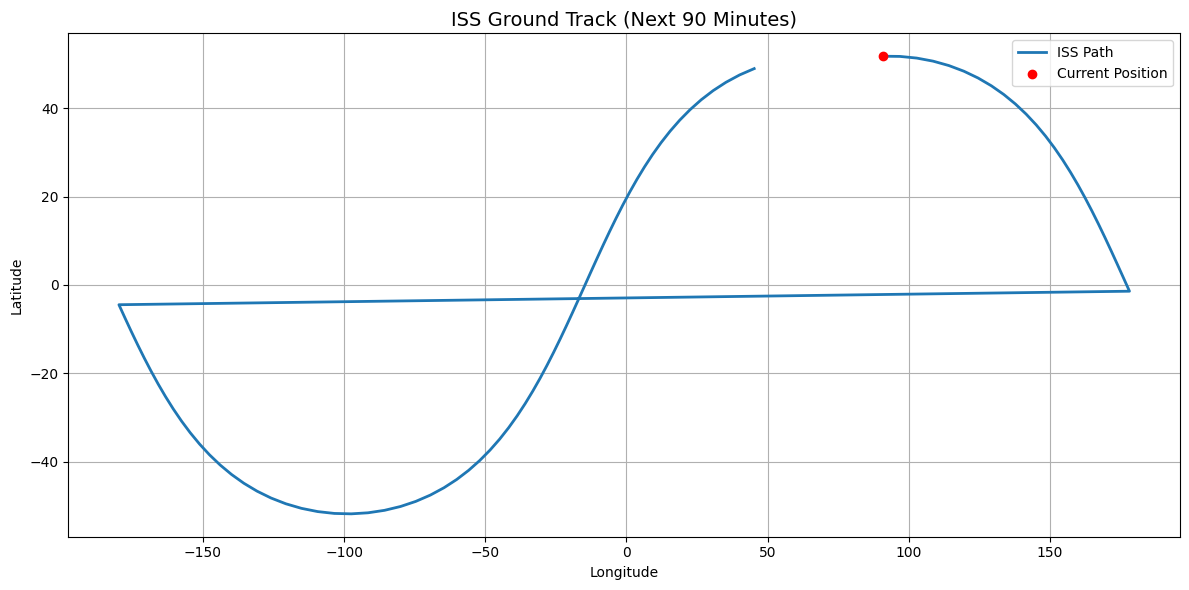

In [36]:
run_iss_tracking("Kolkata", 90)

##  📚 Further Learning & References

- [CelesTrak TLE Services](https://celestrak.com/NORAD/elements/)
- [Open Notify ISS API](http://open-notify.org/Open-Notify-API/ISS-Location-Now/)
- [Skyfield Documentation](https://rhodesmill.org/skyfield/)
- [Matplotlib Basemap/Cartopy](https://matplotlib.org/basemap/)
- [ipywidgets Guide](https://ipywidgets.readthedocs.io/)

## 🔗 GitHub Repository

The complete source code and project resources can be accessed on GitHub:  
[👉 View on GitHub](https://github.com/cosmos24ab/ISS_tracking_ISA_2025/tree/main)
